Goal: Violin plots of the following data

Y-axis (1 plot for each variable): Weight, Bending Stiffness (D11) above "weak layer"
    Weak Layer is: 
    - Failure layer of test (ECT, PST)
    - failure layer of avalanche (Crown, flank)
    - or identified layer of concern (Layer of concern)

X-axis: Different groups of pits
    - ECTP
    - ECTN
    - PST < 0.5
    - Pits on crowns
    - Pits on flanks
    - Layer of concern


Larger dataset
- Last five snow years


Need to code

Weight
- Density from hand hardness and grain form
- Weight above weak layer (from layer densities and thickensses)

Bending stiffness
- Elastic modulus (p 1481)
    

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from snowpylot import caaml_parser

parse_pits function: Parses all pits in a specified folder

In [15]:
def parse_pits(folder_path):
    """
    Function to parse CAAML files in the specified folder
    """

    files = [
        f for f in os.listdir(folder_path) if f.endswith(".xml")
    ]  # List of all .xml files in the folder

    pits_list = []

    for file in files:  # iterate through each file in the folder
        file_path = folder_path + "/" + file  # create the file path
        pit = caaml_parser(file_path)  # parse the file
        pits_list.append(pit)

    return pits_list

Specify folders for 2020-2024 Water Years and parse files

In [16]:
# Define folders and parse pits

pits_19_20 = parse_pits("../snowpits/by_season/2019-2020")
pits_20_21 = parse_pits("../snowpits/by_season/2020-2021")
pits_21_22 = parse_pits("../snowpits/by_season/2021-2022")
pits_22_23 = parse_pits("../snowpits/by_season/2022-2023")
pits_23_24 = parse_pits("../snowpits/by_season/2023-2024")

all_pits = (
    pits_19_20 + pits_20_21 + pits_21_22 + pits_22_23 + pits_23_24
)  # list of all pits

Geldsetzer table of density from hand hardness and grain form

In [17]:
geldsetzer_df = pd.read_csv('geldsetzer_table.csv', index_col=0)

def get_density(hand_hardness, grain_form, df=geldsetzer_df):
    """
    Get density value for a specific hand hardness and grain form combination.
    
    Parameters:
    df (pd.DataFrame): The Geldsetzer table DataFrame
    hand_hardness (str): Hand hardness value (e.g., 'F-', '4F+', 'P-', etc.)
    grain_form (str): Grain form (e.g., 'PP', 'DF', 'RG', 'FC', 'DH', etc.)
    
    Returns:
    float: Density value, or NaN if not available
    """
    try:
        return df.loc[hand_hardness, grain_form]
    except KeyError as e:
        print(f"Key not found: {e}")
        return np.nan

Find weight above indicated layer of concern

In [18]:
# Find pits with indicated layer of concern
pits_with_layer_of_concern = []

for pit in all_pits:
    layers = pit.snow_profile.layers
    for layer in layers:
        if layer.layer_of_concern:
            pits_with_layer_of_concern.append(pit)


print("Num pits: ", len(all_pits))
print("Num pits with layer of concern: ", len(pits_with_layer_of_concern))

Num pits:  31170
Num pits with layer of concern:  22545


In [19]:
# Find pits with hardness and grain form info

pits_with_hardness_and_grain_form = []

for pit in pits_with_layer_of_concern:
    all_layers_info = True # NOTE: Need to check if all layers above layer of concern, not ALL layers
    layers = pit.snow_profile.layers
    for layer in layers:
        if layer.hardness is None or layer.grain_form_primary is None:
            all_layers_info = False
    if all_layers_info: # If all layers have hardness and grain form info
        pits_with_hardness_and_grain_form.append(pit)

print("Num pits with hardness and grain form info: ", len(pits_with_hardness_and_grain_form))


Num pits with hardness and grain form info:  9316


In [20]:
results = []
for pit in pits_with_hardness_and_grain_form:
    layers = pit.snow_profile.layers
    weight_above_layer_of_concern = 0
    for layer in layers:
        #Convert grain form to code needed for Geldsetzer table
        if layer.grain_form_primary.sub_grain_class_code in ["PPgp","RGmx","FCmx"]:
            grain_form = layer.grain_form_primary.sub_grain_class_code
        else:
            grain_form = layer.grain_form_primary.basic_grain_class_code

        # Get density
        density = get_density(layer.hardness, grain_form)
        
        # Calculate weight
        thickness_m = (layer.thickness[0])/100 # convert cm to m
        weight = thickness_m * density # Weight in kg (assuming 1 m^2 cross-section)
        weight_above_layer_of_concern += weight

        if layer.layer_of_concern:
            break #Only calculate weight above layer of concern
    # Capture info for pit
    pit_info = {
        "pit_id": pit.core_info.pit_id,
        "weight_above_layer_of_concern": weight_above_layer_of_concern
    }
    results.append(pit_info)

results_df = pd.DataFrame(results)

Key not found: 'IF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: None
Key not found: 'IF'
Key not found: None
Key not found: 'SH'
Key not found: 'MF'
Key not found: 'SH'
Key not found: 'MF'
Key not found: None
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'SH'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'IF'
Key not found: 'SH'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'SH'
Key not found: 'IF'
Key not found: 'SH'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'IF'
Key not found: 'IF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'MF'
Key not found: 'SH'


In [21]:
non_nan_results = results_df[results_df['weight_above_layer_of_concern'].notna()]
print("num pits with weight above layer of concern: ", len(non_nan_results))

print("mean weight above layer of concern (kg): ", non_nan_results['weight_above_layer_of_concern'].mean())

print("median weight above layer of concern (kg): ", non_nan_results['weight_above_layer_of_concern'].median())



num pits with weight above layer of concern:  3925
mean weight above layer of concern (kg):  107.46370056050955
median weight above layer of concern (kg):  83.2


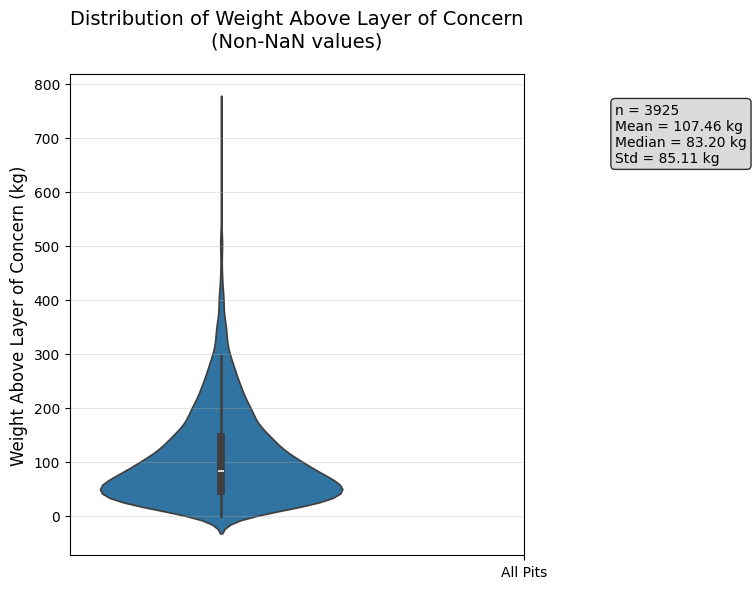


Summary Statistics:
Count: 3925
Mean: 107.46 kg
Median: 83.20 kg
Standard Deviation: 85.11 kg
Min: 0.34 kg
Max: 745.30 kg


In [28]:
# Create violin plot of weight_above_layer_of_concern for non-NaN values
if len(non_nan_results) > 0:
    plt.figure(figsize=(8, 6))
    sns.violinplot(y=non_nan_results['weight_above_layer_of_concern'])
    plt.title('Distribution of Weight Above Layer of Concern (Non-NaN values)')  
    plt.ylabel('Weight Above Layer of Concern (kg)')
    
    # Customize the plot
    plt.title('Distribution of Weight Above Layer of Concern\n(Non-NaN values)', fontsize=14, pad=20)
    plt.ylabel('Weight Above Layer of Concern (kg)', fontsize=12)
    plt.xticks([1], ['All Pits'])
    plt.grid(True, alpha=0.3)
    
    # Add some statistics as text
    mean_val = non_nan_results['weight_above_layer_of_concern'].mean()
    median_val = non_nan_results['weight_above_layer_of_concern'].median()
    std_val = non_nan_results['weight_above_layer_of_concern'].std()
    
    stats_text = f'n = {len(non_nan_results)}\nMean = {mean_val:.2f} kg\nMedian = {median_val:.2f} kg\nStd = {std_val:.2f} kg'
    plt.text(1.3, plt.ylim()[1] * 0.8, stats_text, fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nSummary Statistics:")
    print(f"Count: {len(non_nan_results)}")
    print(f"Mean: {mean_val:.2f} kg")
    print(f"Median: {median_val:.2f} kg")
    print(f"Standard Deviation: {std_val:.2f} kg")
    print(f"Min: {non_nan_results['weight_above_layer_of_concern'].min():.2f} kg")
    print(f"Max: {non_nan_results['weight_above_layer_of_concern'].max():.2f} kg")
    
else:
    print("No non-NaN values found to plot.")

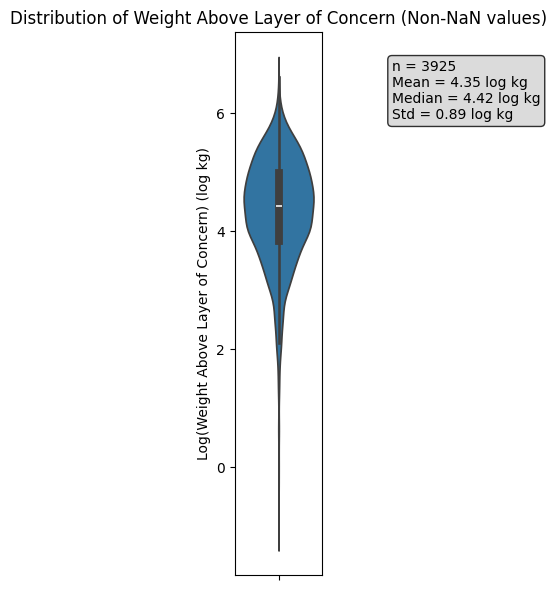


Summary Statistics (Log-Transformed):
Count: 3925
Mean: 4.35 log kg
Median: 4.42 log kg
Standard Deviation: 0.89 log kg
Min: -1.07 log kg
Max: 6.61 log kg


In [29]:
# Create violin plot of weight_above_layer_of_concern for non-NaN values
if len(non_nan_results) > 0:
    plt.figure(figsize=(8, 6))
    sns.violinplot(y=np.log(non_nan_results['weight_above_layer_of_concern']))
    plt.title('Distribution of Weight Above Layer of Concern (Non-NaN values)')  
    plt.ylabel('Log(Weight Above Layer of Concern) (log kg)')
    
    # Calculate log-transformed statistics
    log_data = np.log(non_nan_results['weight_above_layer_of_concern'].values)
    mean_val = np.mean(log_data)
    median_val = np.median(log_data)
    std_val = np.std(log_data)
    
    stats_text = f'n = {len(non_nan_results)}\nMean = {mean_val:.2f} log kg\nMedian = {median_val:.2f} log kg\nStd = {std_val:.2f} log kg'
    plt.text(1.3, plt.ylim()[1] * 0.8, stats_text, fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nSummary Statistics (Log-Transformed):")
    print(f"Count: {len(non_nan_results)}")
    print(f"Mean: {mean_val:.2f} log kg")
    print(f"Median: {median_val:.2f} log kg")
    print(f"Standard Deviation: {std_val:.2f} log kg")
    print(f"Min: {np.min(log_data):.2f} log kg")
    print(f"Max: {np.max(log_data):.2f} log kg")
    
else:
    print("No non-NaN values found to plot.")

### Weight Above ECTP Failure

In [ ]:
for pit in all_pits:
    layers = pit.snow_profile.layers
    weight_above_layer_of_concern = 0
    for layer in layers:
        #Convert grain form to code needed for Geldsetzer table
        if layer.grain_form_primary.sub_grain_class_code in ["PPgp","RGmx","FCmx"]:
            grain_form = layer.grain_form_primary.sub_grain_class_code
        else:
            grain_form = layer.grain_form_primary.basic_grain_class_code
            